<a href="https://colab.research.google.com/github/Mohanandu/Data-Analytics-on-FIFA/blob/main/bank_customer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shantanudhakadd_bank_customer_churn_prediction_path = kagglehub.dataset_download('shantanudhakadd/bank-customer-churn-prediction')

print('Data source import complete.')


100%|██████████| 262k/262k [00:00<00:00, 19.2MB/s]

Extracting files...
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [10]:
random_state=42
shantanudhakadd_bank_customer_churn_prediction_path = kagglehub.dataset_download('shantanudhakadd/bank-customer-churn-prediction')

# Data preprocessing

In [11]:
import os
csv_file_path = os.path.join(shantanudhakadd_bank_customer_churn_prediction_path, 'Churn_Modelling.csv')

In [13]:


df = pd.read_csv(csv_file_path)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [14]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [15]:
df.isna().sum()
# We don't have any NaN

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


([<matplotlib.patches.Wedge at 0x78f05c29c510>,
 [Text(-0.8823432229396718, 0.656864093197697, 'False'),
  Text(0.8823431237559431, -0.6568642264278096, 'True')],
 [Text(-0.4812781216034573, 0.358289505380562, '79.6%'),
  Text(0.48127806750324165, -0.35828957805153244, '20.4%')])

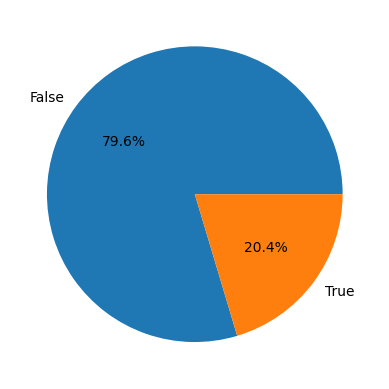

In [16]:
exited = df['Exited'].value_counts()
labels = ['False', 'True']
plt.pie(exited, labels=labels, autopct='%1.1f%%')

In [17]:
# gender = df['Gender'].value_counts()
# labels = ['False', 'True']
# plt.pie(exited, labels=labels, autopct='%1.1f%%')
df['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


In [18]:
df = pd.get_dummies(df, dtype=np.int64)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [19]:
df['BalanceSalaryRatio'] = df['Balance'] / df['EstimatedSalary']
df.drop(['Balance', 'EstimatedSalary'], axis=1, inplace=True)

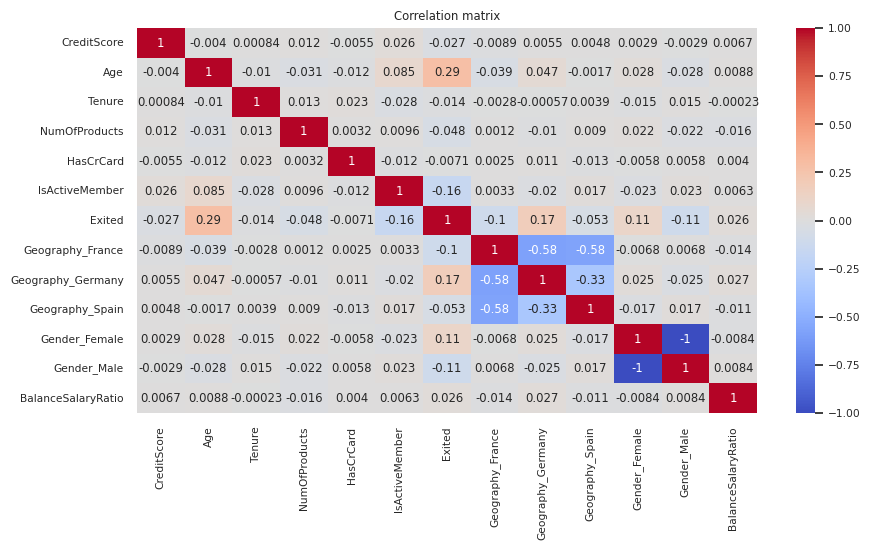

In [20]:
corr_mat = df.corr()
plt.figure(figsize=(10, 5))
sns.set(font_scale=0.7)
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [21]:
Y = df['Exited']
X = df.drop('Exited', axis=1)

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

# Estimators

## Random forest

In [27]:
random_forest_sklearn = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],  # Reduced range for n_estimators
    'max_depth': [10, 20],  # Reduced range for max_depth
    'min_samples_split': [2, 5],  # Reduced range for min_samples_split
    'min_samples_leaf': [1, 5],  # Reduced range for min_samples_leaf
    'class_weight': ['balanced'],
    'random_state': [random_state]
}

grid_search = GridSearchCV(estimator=random_forest_sklearn, param_grid=param_grid, n_jobs=4)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced'], 'max_depth': [10, 20],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200], 'random_state': [42]})

In [28]:
best_params = grid_search.best_params_
best_params

{'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}

In [29]:
y_pred = grid_search.predict(x_test)
roc_auc_score(y_test, y_pred)

np.float64(0.7112450142585477)

In [30]:
accuracy_score(y_test, y_pred)

0.8665

In [31]:
recall_score(y_test, y_pred)

0.455470737913486

### But what if we try to optimize and take only 200 estimators


In [39]:
from sklearn.model_selection import RandomizedSearchCV
# ... (your imports and other code)

# Define parameter distributions instead of a grid
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced'],
    'random_state': [random_state]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=random_forest_sklearn,
    param_distributions=param_dist,
    n_iter=10, # Number of random parameter settings to try
    n_jobs=4, # Adjust based on your resources
    random_state=random_state
)

# Fit the model
random_search.fit(x_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [10, 15, 20, 30],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200],
                                        'random_state': [42]},
                   random_state=42)

In [41]:
y_pred = random_search.predict(x_test) # Use random_search instead of grid_search_200
roc_auc_score(y_test, y_pred)

np.float64(0.7134784047527437)

In [42]:
accuracy_score(y_test, y_pred)

0.867

In [43]:
recall_score(y_test, y_pred)

0.46055979643765904

200 estimators isn't much worse, but now we'll look at feature importance for 1000 estimators version

In [44]:
feature_importances = pd.DataFrame(columns=df.drop('Exited', axis=1).columns, data=[grid_search.best_estimator_.feature_importances_])
feature_importances.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,BalanceSalaryRatio
0,0.180007,0.289509,0.106058,0.137233,0.021827,0.039913,0.012708,0.023691,0.010357,0.01032,0.011514,0.156864


## SVC

In [45]:
svc = SVC(kernel='poly', degree=7, random_state=random_state)
svc.fit(x_train, y_train)

SVC(degree=7, kernel='poly', random_state=42)

In [46]:
y_pred = svc.predict(x_test)
roc_auc_score(y_test, y_pred)

np.float64(0.67398278207144)

In [47]:
accuracy_score(y_test, y_pred)

0.8545

In [48]:
recall_score(y_test, y_pred)

0.37659033078880405

## XGBoost

In [49]:
xgb = XGBClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20, 30],
    'learning_rate': [1e-3, 5e-2, 1e-2, 5e-1],
    'random_state': [random_state]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=4)
grid_search_xgb.fit(x_train, y_train)

y_pred = grid_search_xgb.predict(x_test)
roc_auc_score(y_test, y_pred)

np.float64(0.7064393849427837)

In [50]:
feature_importances = pd.DataFrame(columns=df.drop('Exited', axis=1).columns, data=[grid_search_xgb.best_estimator_.feature_importances_])
feature_importances.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,BalanceSalaryRatio
0,0.022885,0.11096,0.021092,0.450964,0.020901,0.181135,0.026441,0.080927,0.026787,0.022009,0.0,0.035898


In [51]:
accuracy_score(y_test, y_pred)

0.8665

In [52]:
recall_score(y_test, y_pred)

0.44274809160305345

In [53]:
grid_search_xgb.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 200,
 'random_state': 42}

## MLP

In [54]:
mlp = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [24, 32, 64, 128],
    'solver': ['adam'],
    'alpha': [1e-4, 5e-3, 1e-3],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [1e-2, 5e-2, 1e-3],
    'early_stopping': [True],
    'random_state': [random_state]
}

grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=4)
grid_search_mlp.fit(x_train, y_train)

y_pred = grid_search_mlp.predict(x_test)
roc_auc_score(y_test, y_pred)

np.float64(0.6941110060786857)

In [55]:
accuracy_score(y_test, y_pred)

0.8575

In [56]:
recall_score(y_test, y_pred)

0.42493638676844786

In [57]:
grid_search_mlp.best_params_

{'alpha': 0.0001,
 'early_stopping': True,
 'hidden_layer_sizes': 64,
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.05,
 'random_state': 42,
 'solver': 'adam'}

## Logistic regression with L1

In [58]:
logi = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear', C=0.01, random_state=random_state)
logi.fit(x_train, y_train)
y_pred = logi.predict(x_test)

In [59]:
accuracy_score(y_test, y_pred)

0.7075

In [60]:
recall_score(y_test, y_pred)

0.7582697201017812

In [61]:
feature_importances = pd.DataFrame(columns=df.drop('Exited', axis=1).columns, data=logi.coef_)
feature_importances.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,BalanceSalaryRatio
0,-0.00726,0.709089,0.0,-0.030646,0.0,-0.376035,-0.009748,0.309592,0.0,0.198236,0.0,0.0


# Conclusion
## Why recall?
    Recall's really important metric for this task because recall shows, how many positives from all positives we've detected and we need to detect as much customers, that'll potentially leave, as possible, and it's better for us because it's more important to retain client than anything else
## Classifier model
- RandomForestClassifier's shown accuracy of 0.87 and recall of 0.46 that means almost half of positives (customer's exited) have been detected
- The best parameters for classifier is:
- 1. class_weight = balanced
  2. max_depth = 20
  3. min_samples_leaf = 1
  4. min_samples_split = 2
  5. n_estimators = 1000
- LogisticRegression's shown best performance among all classifiers on recall (0.75), but accuracy's a bit lower (0.7). I think that this estimator's much better because of high recall increase and relatively small accuracy decrease.
## Features
- Adding new feature "BalanceSalaryRatio" and removing correlating "Balance" and "EstimatedSalary" improves model's performance
- Top 3 most important features are:
- 1. Age (0.28)
  2. CreditScore (0.18)
  3. BalanceSalaryRatio (0.16)
- But if we use Logistic Regression with L1 penalty:
- 1. Age (0.7)
  2. Geography_Germany (means that client's from Germany) (0.3)
  3. IsActiveMember (-0.37) (inverse proportionality)
- All in all, because LogisticRegression's shown better results, hence, I'll base my conclusions on it.
- The most important features are:
- 1. Age
  2. Geography_Germany
  3. IsActiveMember
  
## Experiments
- I tried RandomForest with different n_estimators and here's the results of 2 experiments:
  1. With n_estimators = 200: accuracy = 0.867, recall = 0.46
  2. With n_estimators = 1000: accuracy = 0.8675, recall = 0.46
